# CNN-RNN

## Import Statements

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! pip install aimodelshare --upgrade

In [ ]:
# ! pip install transformers seaborn ipywidgets tqdm pyyaml h5py

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import IPython.display as display
import matplotlib.pyplot as plt
import seaborn as sns

import random
import time
from glob import glob
from copy import deepcopy

import PIL
from tqdm import tqdm
# from tqdm.notebook import tqdm

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [ ]:
ROOT_DIR = '/home/sushie/'
# ROOT_DIR = '/content/drive/MyDrive/Coursework/Fall \'22/NNDL/Project/NNDL Project/'
DATA_DIR = ROOT_DIR + 'data/data_split/train/superclass'
TEST_DATA_DIR = ROOT_DIR + 'data/data_split/test'
MODEL_DIR = ROOT_DIR + 'models/cnn_rnn/'

In [ ]:
batch_size = 64
img_size = (32, 32)

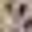

In [ ]:
sample_image = keras.preprocessing.image.load_img(
    glob(DATA_DIR+'/*/*.jpg')[0], grayscale=False, color_mode="rgb", target_size=img_size, interpolation="bicubic"
)
sample_image

## Load Data

In [ ]:
input_shape = keras.preprocessing.image.img_to_array(sample_image).shape

In [ ]:
superclass_idx_to_name_map = pd.read_csv(ROOT_DIR + 'Released_Data/super_classes_mapping.csv')
superclass_idx_to_name_map = {k:v for k,v in superclass_idx_to_name_map.values}

subclass_idx_to_name_map = pd.read_csv(ROOT_DIR + 'Released_Data/sub_classes_mapping.csv')
subclass_idx_to_name_map = {k:v for k,v in subclass_idx_to_name_map.values}

sub_to_superclass_idx_map = pd.read_csv(ROOT_DIR + 'Released_Data/train_data.csv')
sub_to_superclass_idx_map = {k:v for k, v in zip(sub_to_superclass_idx_map.subclass_index.values, 
                                                 sub_to_superclass_idx_map.superclass_index.values)}

idx_to_vocab_input_map = superclass_idx_to_name_map.copy()
idx_to_vocab_input_map[3] = '[START]'
vocab_input_to_idx_map = {v:k for k,v in idx_to_vocab_input_map.items()}
idx_to_vocab_input_map, vocab_input_to_idx_map

({0: 'bird', 1: 'dog', 2: 'reptile', 3: '[START]'},
 {'bird': 0, 'dog': 1, 'reptile': 2, '[START]': 3})

In [ ]:
def get_dataloaders(batch_size, validation_split, image_size, interpolation, seed):
    # Load train data
    labels_df = pd.read_csv(ROOT_DIR+'Released_Data/train_data.csv')
    file_paths = {file_path.rsplit('/')[-1]: file_path for file_path in glob(DATA_DIR + f'/*/*.jpg')}
    labels_df = labels_df[labels_df.image.isin(file_paths.keys())]
    images = [np.array(keras.preprocessing.image.load_img(file_paths[i], color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=image_size, 
                                                 interpolation=interpolation)) 
        for i in tqdm(labels_df.image.values, desc='Loading images')]
    labels_superclass = labels_df.superclass_index.astype(int).values.tolist()
    labels_subclass = labels_df.subclass_index.astype(int).values.tolist()
    labels = list(zip(labels_superclass, labels_subclass))

    images = np.array(images)
    labels = np.array(labels)
    sequences = np.stack([np.ones_like(labels_superclass)*vocab_input_to_idx_map['[START]'], labels_superclass], axis=1)

    # Split train and val
    images_train, images_val, sequences_train, \
        sequences_val, labels_train, labels_val = train_test_split(images, sequences, labels, 
                                                                   test_size=validation_split, random_state=seed, 
                                                                   stratify=labels_subclass)
    # Load test data
    truth_df = pd.read_csv(TEST_DATA_DIR+'/Truth.csv')
    file_paths = {file_path.rsplit('/')[-1]: file_path for file_path in glob(TEST_DATA_DIR + f'/*.jpg')}
    images = [np.array(keras.preprocessing.image.load_img(file_paths[i], color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=image_size, 
                                                 interpolation=interpolation)) 
        for i in tqdm(truth_df.image.values, desc='Loading test images')]
    labels_superclass = truth_df.superclass_index.astype(int).values.tolist()
    labels_subclass = truth_df.subclass_index.astype(int).values.tolist()
    labels = list(zip(labels_superclass, labels_subclass))

    images_test = np.array(images)
    labels_test = np.array(labels)
    sequences_test = np.stack([np.ones_like(labels_superclass)*vocab_input_to_idx_map['[START]'], labels_superclass], axis=1)
    
    print()
    print(f"Training samples: {len(images_train)}")
    print(f"Validation samples: {len(images_val)}")
    print(f"Testing samples: {len(images_test)}")

    train_ds = tf.data.Dataset.from_tensor_slices(((images_train, sequences_train), 
                                                   (labels_train[:, 0].reshape(-1, 1), labels_train[:, 1].reshape(-1, 1)))).shuffle(buffer_size=1024).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices(((images_val, sequences_val), 
                                                 (labels_val[:, 0].reshape(-1, 1), labels_val[:, 1].reshape(-1, 1)))).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(((images_test, sequences_test), 
                                                  (labels_test[:, 0].reshape(-1, 1), labels_test[:, 1].reshape(-1, 1)))).batch(batch_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataloaders(batch_size=batch_size, validation_split=.2, 
                                            image_size=img_size, interpolation='bicubic', 
                                            seed=42)

Loading test images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1942/1942 [00:00<00:00, 4291.14it/s]
2022-12-16 03:28:11.483443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



Training samples: 3624
Validation samples: 906
Testing samples: 1942


2022-12-16 03:28:11.494613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 03:28:11.495445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 03:28:11.497878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 03:28:11.498285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Model

In [ ]:
class CNNEncoder(tf.keras.Model):
    def __init__(self, input_shape, embed_size, freeze_pretrained=True):
        super(CNNEncoder, self).__init__()
        self.rescaling = layers.Rescaling(1./255, name='rescale')
        self.data_augmentation = keras.Sequential(
            [
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(factor=0.02),
                layers.RandomZoom(
                    height_factor=0.2, width_factor=0.2
                ),
            ],
            name="data_augmentation",
        )
        self.convnet = keras.Sequential([
            keras.applications.vgg16.VGG16(
                include_top=False,
                weights='imagenet',
                input_shape=input_shape,),
            layers.GlobalAveragePooling2D()
        ], name='convnet')
        
        if freeze_pretrained:
            self.convnet.trainable = False

        self.image_encoding = keras.Sequential([
            layers.Dense(1024, activation='relu', name='dense_relu'),
            layers.Dropout(0.3),
            layers.Dense(embed_size, name='dense_out'),
            layers.BatchNormalization(momentum=0.1, name='batch_norm_out')
        ], name='image_encoding_out')

    def call(self, inputs, training=False):
        inputs = self.rescaling(inputs)
        inputs = self.data_augmentation(inputs, training=training)
        features = self.convnet(inputs, training=training)
        image_encoding = self.image_encoding(features, training=training)
        return image_encoding

encoder = CNNEncoder(input_shape, embed_size=512,
                     freeze_pretrained=True)
encoder._name = "cnn_encoder"
encoder.build((None, *input_shape))
encoder.summary()

Model: "cnn_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescale (Rescaling)         multiple                  0         
                                                                 
 data_augmentation (Sequenti  (None, 32, 32, 3)        0         
 al)                                                             
                                                                 
 convnet (Sequential)        (None, 512)               14714688  
                                                                 
 image_encoding_out (Sequent  (None, 512)              1052160   
 ial)                                                            
                                                                 
Total params: 15,766,848
Trainable params: 1,051,136
Non-trainable params: 14,715,712
_________________________________________________________________


In [ ]:
class RNNDecoder(tf.keras.Model):
    def __init__(self, input_size, embedding_size, hidden_size, num_superclasses, num_subclasses, ):
        super(RNNDecoder, self).__init__()

        self.embedding = layers.Embedding(input_dim=input_size, #4
                                          output_dim=embedding_size,
                                          input_length=2,
                                          name='input_embedding')
        
        self.lstm = layers.LSTM(hidden_size, activation='tanh', 
                                recurrent_activation='sigmoid', 
                                dropout=0.3,
                                recurrent_dropout=0.3, 
                                return_sequences=True, return_state=True, 
                                unroll=True,
                                name='lstm')
        
        self.cls_super = keras.Sequential([
            layers.Dense(128, activation='relu', name='dense_super_relu'),
            layers.Dropout(0.3),
            layers.Dense(num_superclasses, name='dense_super'),
        ], name='cls_superclass')

        self.cls_sub = keras.Sequential([
            layers.Dense(128, activation='relu', name='dense_sub_relu'),
            layers.Dropout(0.3),
            layers.Dense(num_subclasses, name='dense_sub'),
        ], name='cls_subclass')

    def call(self, inputs, encoder_state=tf.zeros((batch_size, 512)), training=False):
        if not training:
            # At inference, one timestep at a time
            # Here, first time step: start token
            input_embeds = tf.expand_dims(self.embedding(inputs), axis=1)   # 64 x 1 x 128
            output, h_, c_ = self.lstm(input_embeds, initial_state=[encoder_state, encoder_state], training=training)     # 64 x 1 x 512
        else:
            # Training, timeshifted input
            # First times step: start token
            # Second time step: embedding for first target word (teacher forcing)
            input_embeds = self.embedding(inputs)       # 64 x 2 x 128
            output, h_, c_ = self.lstm(input_embeds, initial_state=[encoder_state, encoder_state], training=training)     # 64 x 2 x 512

        output_superclass = self.cls_super(output[:, 0, :], training=training)        # 64 x 3

        if not training:
            # Inference, second timestep
            # Output of inference at first timestep -> argmax
            # Pass through embedding layer -> lstm -> generate output
            inputs = tf.math.argmax(output_superclass, axis=1)
            input_embeds = tf.expand_dims(self.embedding(inputs), axis=1)   # 64 x 1 x 128
            output_t2, h_, c_ = self.lstm(input_embeds, initial_state=[h_, c_], 
                                          training=training)        # 64 x 1 x 512
            output = tf.concat([output, output_t2], axis=1)      

        output_subclass = self.cls_sub(output[:, 1, :], training=training)        # 64 x 90
        return output_superclass, output_subclass

decoder = RNNDecoder(input_size=len(idx_to_vocab_input_map.keys()), embedding_size=128, hidden_size=512, 
                     num_superclasses=len(superclass_idx_to_name_map.keys()), 
                     num_subclasses=len(subclass_idx_to_name_map.keys()))
decoder._name = "rnn_decoder"
decoder.build((64,))
decoder.summary()

Model: "rnn_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embedding (Embedding)  multiple                 512       
                                                                 
 lstm (LSTM)                 multiple                  1312768   
                                                                 
 cls_superclass (Sequential)  (64, 3)                  66051     
                                                                 
 cls_subclass (Sequential)   (64, 90)                  77274     
                                                                 
Total params: 1,456,605
Trainable params: 1,456,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class HierarchicalImageClassifier(tf.keras.Model):
    def __init__(self, image_input_shape, image_embed_size, text_input_size, text_embed_size, 
                 num_superclasses, num_subclasses, freeze_convnet=True):
        super().__init__()
        self.encoder = CNNEncoder(image_input_shape, embed_size=image_embed_size, freeze_pretrained=freeze_convnet)
        self.encoder._name = "cnn_encoder"
        self.decoder = RNNDecoder(input_size=text_input_size, 
                                  embedding_size=text_embed_size, hidden_size=image_embed_size, 
                                  num_superclasses=num_superclasses, 
                                  num_subclasses=num_subclasses)
        self.decoder._name = "rnn_decoder"

    def call(self, inputs, training=False):
        image, sequence = inputs
        image_encoding = self.encoder(image, training=training)
        if training:
            output_superclass, output_subclass = self.decoder(sequence, encoder_state=image_encoding, training=training)
        else:
            output_superclass, output_subclass = self.decoder(sequence[:, 0], encoder_state=image_encoding, training=training)
        return output_superclass, output_subclass


## Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_object = [keras.losses.SparseCategoricalCrossentropy(from_logits=True), keras.losses.SparseCategoricalCrossentropy(from_logits=True)]
loss_weight =  [1, .5]

In [ ]:
model = HierarchicalImageClassifier(image_input_shape=input_shape, 
                                    image_embed_size=512,
                                    text_input_size=len(idx_to_vocab_input_map.keys()),
                                    text_embed_size=128,
                                    num_superclasses=len(superclass_idx_to_name_map.keys()),
                                    num_subclasses=len(subclass_idx_to_name_map.keys()),
                                    freeze_convnet=True)
model.name_ = 'hierarchical_image_classifier'

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    MODEL_DIR + 'checkpoints/weights.{epoch:02d}-{val_loss:.2f}.tf',
    monitor = "val_loss",
    save_weights_only = True,
    save_freq="epoch",
)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_object,
              loss_weights=loss_weight,
              metrics='accuracy')

In [ ]:
num_epochs = 25
model.fit(train_ds, validation_data=val_ds, 
          epochs=num_epochs, callbacks=[model_checkpoint_callback])

Epoch 1/25


2022-12-14 03:30:40.395971: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


57/57 [==============================] - 16s 115ms/step - loss: 3.1927 - output_1_loss: 0.9285 - output_2_loss: 4.5285 - output_1_accuracy: 0.5516 - output_2_accuracy: 0.0113 - val_loss: 2.9423 - val_output_1_loss: 0.7112 - val_output_2_loss: 4.4622 - val_output_1_accuracy: 0.6766 - val_output_2_accuracy: 0.0210
Epoch 2/25
57/57 [==============================] - 6s 109ms/step - loss: 3.0154 - output_1_loss: 0.7773 - output_2_loss: 4.4762 - output_1_accuracy: 0.6548 - output_2_accuracy: 0.0229 - val_loss: 2.8595 - val_output_1_loss: 0.6592 - val_output_2_loss: 4.4006 - val_output_1_accuracy: 0.7208 - val_output_2_accuracy: 0.0430
Epoch 3/25
57/57 [==============================] - 5s 93ms/step - loss: 2.9518 - output_1_loss: 0.7448 - output_2_loss: 4.4141 - output_1_accuracy: 0.6760 - output_2_accuracy: 0.0306 - val_loss: 2.8083 - val_output_1_loss: 0.6462 - val_output_2_loss: 4.3244 - val_output_1_accuracy: 0.7274 - val_output_2_accuracy: 0.0530
Epoch 4/25
57/57 [=====================

### Fine-tuning

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
loss_object = [keras.losses.SparseCategoricalCrossentropy(from_logits=True), keras.losses.SparseCategoricalCrossentropy(from_logits=True)]
loss_weight =  [.2, .8]

In [ ]:
model.trainable = True

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_object,
              loss_weights=loss_weight,
              metrics='accuracy')

In [ ]:
num_epochs_finetune = 25
model.fit(train_ds, validation_data=val_ds, 
          epochs=num_epochs_finetune, 
          callbacks=[model_checkpoint_callback])

Epoch 1/25
57/57 [==============================] - 14s 165ms/step - loss: 2.4906 - output_1_loss: 0.4986 - output_2_loss: 2.9886 - output_1_accuracy: 0.7972 - output_2_accuracy: 0.1829 - val_loss: 3.0782 - val_output_1_loss: 0.5569 - val_output_2_loss: 3.7085 - val_output_1_accuracy: 0.7726 - val_output_2_accuracy: 0.1534
Epoch 2/25
57/57 [==============================] - 8s 149ms/step - loss: 2.4588 - output_1_loss: 0.4583 - output_2_loss: 2.9589 - output_1_accuracy: 0.8121 - output_2_accuracy: 0.1973 - val_loss: 3.1224 - val_output_1_loss: 0.6028 - val_output_2_loss: 3.7523 - val_output_1_accuracy: 0.7528 - val_output_2_accuracy: 0.1501
Epoch 3/25
57/57 [==============================] - 9s 163ms/step - loss: 2.4647 - output_1_loss: 0.4836 - output_2_loss: 2.9600 - output_1_accuracy: 0.8033 - output_2_accuracy: 0.2012 - val_loss: 3.0720 - val_output_1_loss: 0.5622 - val_output_2_loss: 3.6994 - val_output_1_accuracy: 0.7627 - val_output_2_accuracy: 0.1523
Epoch 4/25
57/57 [=========

In [ ]:
model.summary()

Model: "hierarchical_image_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CNNEncoder)    multiple                  15766848  
                                                                 
 rnn_decoder (RNNDecoder)    multiple                  1456605   
                                                                 
Total params: 17,223,453
Trainable params: 17,222,429
Non-trainable params: 1,024
_________________________________________________________________


# Test

In [ ]:
model = HierarchicalImageClassifier(image_input_shape=input_shape, 
                                    image_embed_size=512,
                                    text_input_size=len(idx_to_vocab_input_map.keys()),
                                    text_embed_size=128,
                                    num_superclasses=len(superclass_idx_to_name_map.keys()),
                                    num_subclasses=len(subclass_idx_to_name_map.keys()),
                                    freeze_convnet=False)
model.compile(optimizer=optimizer,
              loss=loss_object,
              loss_weights=loss_weight,
              metrics='accuracy')

In [ ]:
# just to build model
model.evaluate(test_ds)

2022-12-16 03:28:45.753288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


31/31 [==============================] - 4s 38ms/step - loss: 3.8216 - output_1_loss: 1.0847 - output_2_loss: 4.5059 - output_1_accuracy: 0.3491 - output_2_accuracy: 0.0124


[3.821626901626587,
 1.0846812725067139,
 4.505863189697266,
 0.34912461042404175,
 0.012358393520116806]

In [ ]:
# model.load_weights(MODEL_DIR + 'checkpoints/weights.13-2.97.hdf5')
model.load_weights(MODEL_DIR + 'hierarchical_classifier.tf')

In [ ]:
model.evaluate(test_ds)

31/31 [==============================] - 1s 28ms/step - loss: 3.0478 - output_1_loss: 0.5653 - output_2_loss: 3.6684 - output_1_accuracy: 0.7724 - output_2_accuracy: 0.1586


[3.047783136367798,
 0.5653213262557983,
 3.668398857116699,
 0.7723996043205261,
 0.1585993766784668]

In [ ]:
test_preds_super, test_preds_sub = model.predict(test_ds)

31/31 [==============================] - 1s 25ms/step


# Model Share

In [ ]:
!pip install aimodelshare --upgrade

In [ ]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/neuralnet_competition_data-repository:latest')


Data downloaded successfully.


In [ ]:
! unzip neuralnet_competition_data/X_test.zip

In [ ]:
def get_test_dataloader(batch_size, image_size, interpolation):
    # Load train data
    file_paths = [('test_shuffle/' + str(i) + '.jpg') for i in range(0, 9127)]
    images = [np.array(keras.preprocessing.image.load_img(i, color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=image_size, 
                                                 interpolation=interpolation)) 
        for i in tqdm(file_paths, desc='Loading images')]

    images = np.array(images)
    sequences = np.stack([np.ones(images.shape[0])*vocab_input_to_idx_map['[START]'], np.ones(images.shape[0])*-1], axis=1)
    labels = np.ones(images.shape[0])*-1

    print()
    print(f"Testing samples: {len(images)}")

    test_ds = tf.data.Dataset.from_tensor_slices(((images, sequences), (labels, labels))).batch(batch_size)
    return test_ds

In [ ]:
modelshare_test_ds = get_test_dataloader(batch_size, img_size, 'bicubic')

Loading images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9127/9127 [00:02<00:00, 4312.53it/s]



Testing samples: 9127


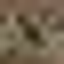

In [ ]:
file_paths = [('test_shuffle/' + str(i) + '.jpg') for i in range(0, 9127)]
keras.preprocessing.image.load_img(file_paths[3], color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=(64, 64), 
                                                 interpolation='bicubic')

In [ ]:
logits_superclass, logits_subclass = model.predict(modelshare_test_ds)

143/143 [==============================] - 4s 28ms/step


In [ ]:
probas_super = tf.nn.softmax(logits_superclass, axis=1)
probas_sub = tf.nn.softmax(logits_subclass, axis=1)

In [ ]:
np.argmax(probas_sub.numpy(), axis=1)[np.max(probas_sub.numpy(), axis=1) <=.3]

array([70, 40, 62, ..., 37, 21, 88])

In [ ]:
predictions_df = pd.DataFrame({'predictions': np.argmax(probas_sub, axis=1).tolist()})

In [ ]:
predictions_df.loc[np.max(probas_sub.numpy(), axis=1) <=.3, 'predictions'] = 89

In [ ]:
predictions_df.predictions = predictions_df.predictions.map(subclass_idx_to_name_map)

In [ ]:
predictions_df

,predictions
0,novel
1,novel
2,novel
3,novel
4,ptarmigan
...,...
9122,novel
9123,novel
9124,novel
9125,novel


In [ ]:
predictions_df.to_csv('predictions_subclass.csv', index=False)

In [ ]:
preds_super = [superclass_idx_to_name_map[i] for i in preds_super]
preds_sub = [subclass_idx_to_name_map[i] for i in preds_sub]

In [ ]:
preds_super_df = pd.DataFrame({'predictions': preds_super})
preds_super_df

,predictions
0,reptile
1,bird
2,reptile
3,reptile
4,bird
...,...
9122,dog
9123,dog
9124,dog
9125,dog


In [ ]:
preds_sub_df = pd.DataFrame({'predictions': preds_sub})
preds_sub_df

,predictions
0,"tree frog, tree-frog"
1,"red-backed sandpiper, dunlin, Erolia alpina"
2,"common newt, Triturus vulgaris"
3,"spotted salamander, Ambystoma maculatum"
4,ptarmigan
...,...
9122,Rhodesian ridgeback
9123,Shih-Tzu
9124,"Maltese dog, Maltese terrier, Maltese"
9125,Chihuahua
